# USA House Prices Analysis & Prediction
The goal of this project is to explore and understand the factors influencing the real estate market in the United States and build machine learning models to accurately predict house prices.

During EDA, we aim to:

+ Identify key factors that influence house prices (e.g., location, size, number of rooms, year built).
+ Detect outliers and anomalies in the dataset.
+ Analyze the distribution of house prices and uncover trends.
+ Explore correlations between property features and prices.

> Source data: https://www.kaggle.com/datasets/farhankarim1/usa-house-prices

## Import libs

In [419]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import scipy.stats as stats # for one_way_ANOVA, Pearson, Spearman test

## Import raw data

In [420]:
import os
import sys
from google.colab import drive

try:
  drive.mount('/content/drive')
  project_path = "/content/drive/MyDrive/Pytorch pet projects/ML - Projects/ML - USA HOUSE PRICES"
  sys.path.append(os.path.join(project_path, "src"))

  path = "/content/drive/MyDrive/Pytorch pet projects/ML - Projects/ML - USA HOUSE PRICES/data/raw/USA_Housing.csv"
except:
  path = "../data/raw/USA_Housing.csv"



df = pd.read_csv(path)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Discover data

In [421]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 7 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Avg. Area Income              5000 non-null   float64
 1   Avg. Area House Age           5000 non-null   float64
 2   Avg. Area Number of Rooms     5000 non-null   float64
 3   Avg. Area Number of Bedrooms  5000 non-null   float64
 4   Area Population               5000 non-null   float64
 5   Price                         5000 non-null   float64
 6   Address                       5000 non-null   object 
dtypes: float64(6), object(1)
memory usage: 273.6+ KB


In [422]:
df.describe()

,Avg. Area Income,Avg. Area House Age,Avg. Area Number of Rooms,Avg. Area Number of Bedrooms,Area Population,Price
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5.000000e+03
mean,68583.108984,5.977222,6.987792,3.981330,36163.516039,1.232073e+06
std,10657.991214,0.991456,1.005833,1.234137,9925.650114,3.531176e+05
min,17796.631190,2.644304,3.236194,2.000000,172.610686,1.593866e+04
25%,61480.562388,5.322283,6.299250,3.140000,29403.928702,9.975771e+05
50%,68804.286404,5.970429,7.002902,4.050000,36199.406689,1.232669e+06
75%,75783.338666,6.650808,7.665871,4.490000,42861.290769,1.471210e+06
max,107701.748378,9.519088,10.759588,6.500000,69621.713378,2.469066e+06


## Feature engineering
+ Address features in this form is not the most usable.
Creating new features base on ```Address```

In [423]:
# How many of the address contains Military address?
df["Military_address"] = df["Address"].str.extract(r"\b(APO|FPO|DPO)\b", expand=True)
mil_add = df["Military_address"].notna().sum()
print(f"{mil_add} of the address is contains 'APO/FPO/DPO' use a specific set of ZIP Codes assigned to military locations.")

514 of the address is contains 'APO/FPO/DPO' use a specific set of ZIP Codes assigned to military locations.


In [424]:
# Remove the military address
df.drop(df[df['Military_address'].notna()].index, inplace=True)

# Split the Address to Steet and to the City+State+Zip
df[["Street", "CityStateZip"]] = df["Address"].str.split("\n", expand=True)
df[["City", "StateZip"]] = df["CityStateZip"].str.split(", ", expand=True)
df[["State", "Zip"]] = df["StateZip"].str.split(" ", n=1, expand=True)

df.drop(columns=["Address", "CityStateZip", "StateZip", "Military_address"], axis=1, inplace=True)
df.head(5)

,Avg. Area Income,Avg. Area House Age,Avg. Area Number of Rooms,Avg. Area Number of Bedrooms,Area Population,Price,Street,City,State,Zip
0,79545.458574,5.682861,7.009188,4.09,23086.800503,1.059034e+06,208 Michael Ferry Apt. 674,Laurabury,NE,37010-5101
1,79248.642455,6.002900,6.730821,3.09,40173.072174,1.505891e+06,188 Johnson Views Suite 079,Lake Kathleen,CA,48958
2,61287.067179,5.865890,8.512727,5.13,36882.159400,1.058988e+06,9127 Elizabeth Stravenue,Danieltown,WI,06482-3489
5,80175.754159,4.988408,6.104512,4.04,26748.428425,1.068138e+06,06039 Jennifer Islands Apt. 443,Tracyport,KS,16077
6,64698.463428,6.025336,8.147760,3.41,60828.249085,1.502056e+06,4759 Daniel Shoals Suite 442,Nguyenburgh,CO,20247


## Examining categories and numerical variables

In [425]:
cat_cols = df.select_dtypes(include=['object']).columns.tolist()
float_cols = df.select_dtypes(include=['float']).columns.tolist()

print(f"Objects: ${cat_cols}")
print(f"Floats: ${float_cols}")

# Turn Object to categroy
df[cat_cols] = df[cat_cols].astype("category")

Objects: $['Street', 'City', 'State', 'Zip']
Floats: $['Avg. Area Income', 'Avg. Area House Age', 'Avg. Area Number of Rooms', 'Avg. Area Number of Bedrooms', 'Area Population', 'Price']


In [426]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4486 entries, 0 to 4999
Data columns (total 10 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   Avg. Area Income              4486 non-null   float64 
 1   Avg. Area House Age           4486 non-null   float64 
 2   Avg. Area Number of Rooms     4486 non-null   float64 
 3   Avg. Area Number of Bedrooms  4486 non-null   float64 
 4   Area Population               4486 non-null   float64 
 5   Price                         4486 non-null   float64 
 6   Street                        4486 non-null   category
 7   City                          4486 non-null   category
 8   State                         4486 non-null   category
 9   Zip                           4486 non-null   category
dtypes: category(4), float64(6)
memory usage: 766.0 KB


In [427]:
%%writefile  visualization.py

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def show_boxplots(columns: list, df: pd.DataFrame) -> None:
  """
  Creates boxplots for float-type features in the given DataFrame.

    Args:
        columns (list): List of feature names that are of float type.
        df (pd.DataFrame): The DataFrame containing the features.

    Returns:
        None: Displays the boxplots in a grid with up to 3 columns per row.
  """
  row = max(1, np.ceil(len(columns) / 3).astype(int))
  fig, axes = plt.subplots(row, 3, figsize=(15, 5 * row))

  if row == 1:
      axes = np.array(axes).reshape(1, -1)

  for index, name in enumerate(columns):
      r, c = divmod(index, 3)
      sns.boxplot(y=name, data=df, ax=axes[r, c])

  plt.tight_layout()
  plt.show()


def show_histplot(columns: list, df: pd.DataFrame) -> None:
  """
  Creates boxplots for float-type features in the given DataFrame.

    Args:
        columns (list): List of feature names that are of float type.
        df (pd.DataFrame): The DataFrame containing the features.

    Returns:
        None: Displays the boxplots in a grid with up to 3 columns per row.
  """
  row = max(1, np.ceil(len(columns) / 3).astype(int))
  fig, axes = plt.subplots(row, 3, figsize=(15, 5 * row))

  if row == 1:
      axes = np.array(axes).reshape(1, -1)

  for index, name in enumerate(columns):
      r, c = divmod(index, 3)
      sns.histplot(x=name, data=df, ax=axes[r, c])

  plt.tight_layout()
  plt.show()

Overwriting visualization.py


In [428]:
%%writefile data_processing.py

import pandas as pd

def remove_outliers_iqr(columns: list, data: pd.DataFrame) -> pd.DataFrame:
  """
    Removes outliers from the specified columns of a DataFrame using the IQR method.

    The function calculates the interquartile range (IQR) for the given columns and
    removes rows where values are outside the lower and upper bounds
    (Q1 - 1.5 * IQR and Q3 + 1.5 * IQR).

    Args:
        columns (list): List of column names from which outliers should be removed.
        df (pd.DataFrame): The DataFrame containing the data.

    Returns:
        pd.DataFrame: A new DataFrame with outliers removed from the specified columns.
    """
  Q1 = data[float_cols].quantile(0.25)
  Q3 = data[float_cols].quantile(0.75)
  IQR = Q3 - Q1
  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR

  mask = (data[float_cols] >= lower_bound) & (data[float_cols] <= upper_bound)
  return data[mask.all(axis=1)].copy()

Overwriting data_processing.py


In [429]:
df

,Avg. Area Income,Avg. Area House Age,Avg. Area Number of Rooms,Avg. Area Number of Bedrooms,Area Population,Price,Street,City,State,Zip
0,79545.458574,5.682861,7.009188,4.09,23086.800503,1.059034e+06,208 Michael Ferry Apt. 674,Laurabury,NE,37010-5101
1,79248.642455,6.002900,6.730821,3.09,40173.072174,1.505891e+06,188 Johnson Views Suite 079,Lake Kathleen,CA,48958
2,61287.067179,5.865890,8.512727,5.13,36882.159400,1.058988e+06,9127 Elizabeth Stravenue,Danieltown,WI,06482-3489
5,80175.754159,4.988408,6.104512,4.04,26748.428425,1.068138e+06,06039 Jennifer Islands Apt. 443,Tracyport,KS,16077
6,64698.463428,6.025336,8.147760,3.41,60828.249085,1.502056e+06,4759 Daniel Shoals Suite 442,Nguyenburgh,CO,20247
...,...,...,...,...,...,...,...,...,...,...
4991,74102.191890,5.657841,7.683993,3.13,24041.270592,1.263721e+06,2871 John Lodge,Amychester,GU,61734-5597
4993,69639.140896,5.007510,7.778375,6.05,54056.128430,1.381831e+06,5259 David Causeway Apt. 975,South Alexstad,IL,42719-2498
4994,73060.846226,5.293682,6.312253,4.16,22695.695480,9.053549e+05,5224 Lamb Passage,Nancystad,GA,16579
4997,63390.686886,7.250591,4.805081,2.13,33266.145490,1.030730e+06,4215 Tracy Garden Suite 076,Joshualand,VA,01707-9165


### Remove outliers (IQR)

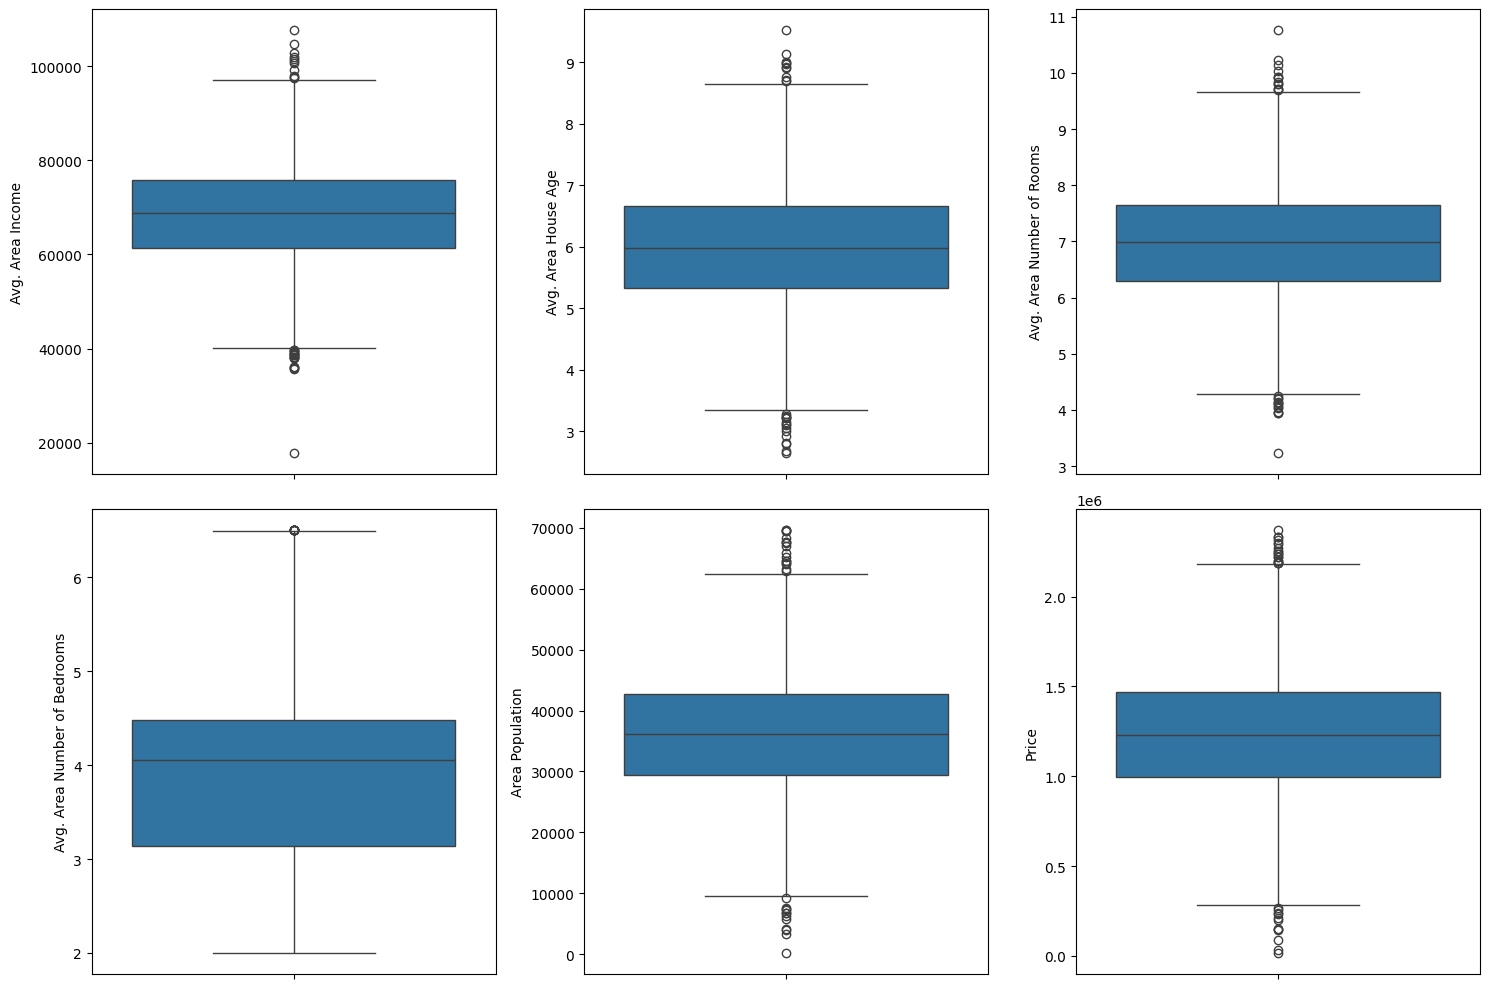

In [430]:
show_boxplots(float_cols, df)

In [431]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4486 entries, 0 to 4999
Data columns (total 10 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   Avg. Area Income              4486 non-null   float64 
 1   Avg. Area House Age           4486 non-null   float64 
 2   Avg. Area Number of Rooms     4486 non-null   float64 
 3   Avg. Area Number of Bedrooms  4486 non-null   float64 
 4   Area Population               4486 non-null   float64 
 5   Price                         4486 non-null   float64 
 6   Street                        4486 non-null   category
 7   City                          4486 non-null   category
 8   State                         4486 non-null   category
 9   Zip                           4486 non-null   category
dtypes: category(4), float64(6)
memory usage: 766.0 KB


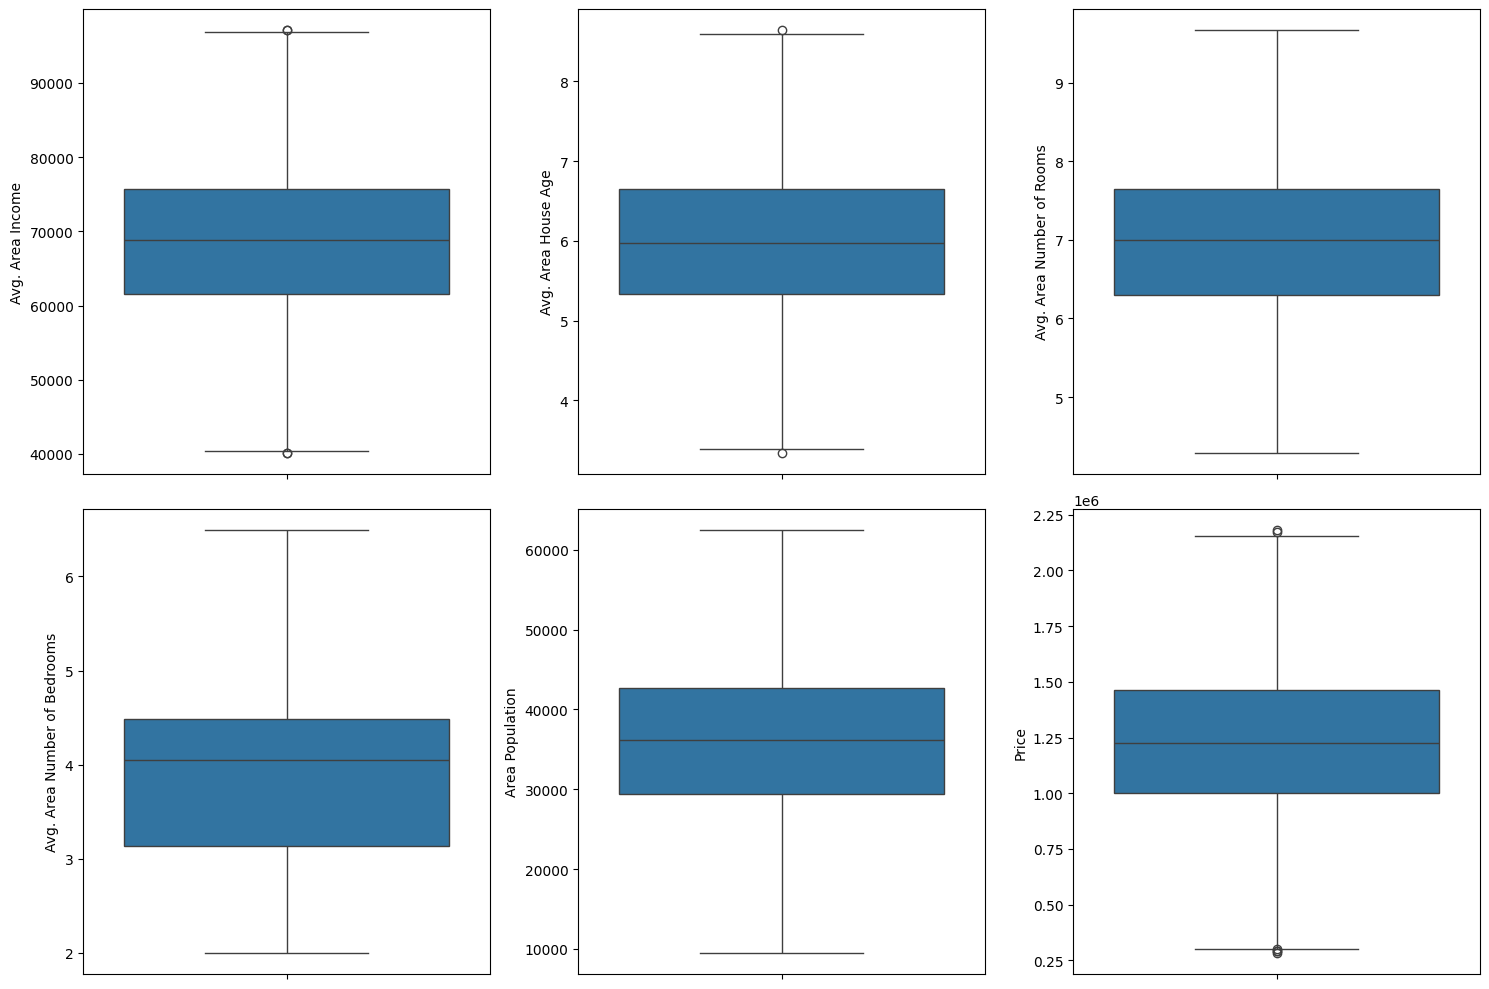

In [432]:
df = remove_outliers_iqr(float_cols, df)
show_boxplots(float_cols, df)

## Statistical test

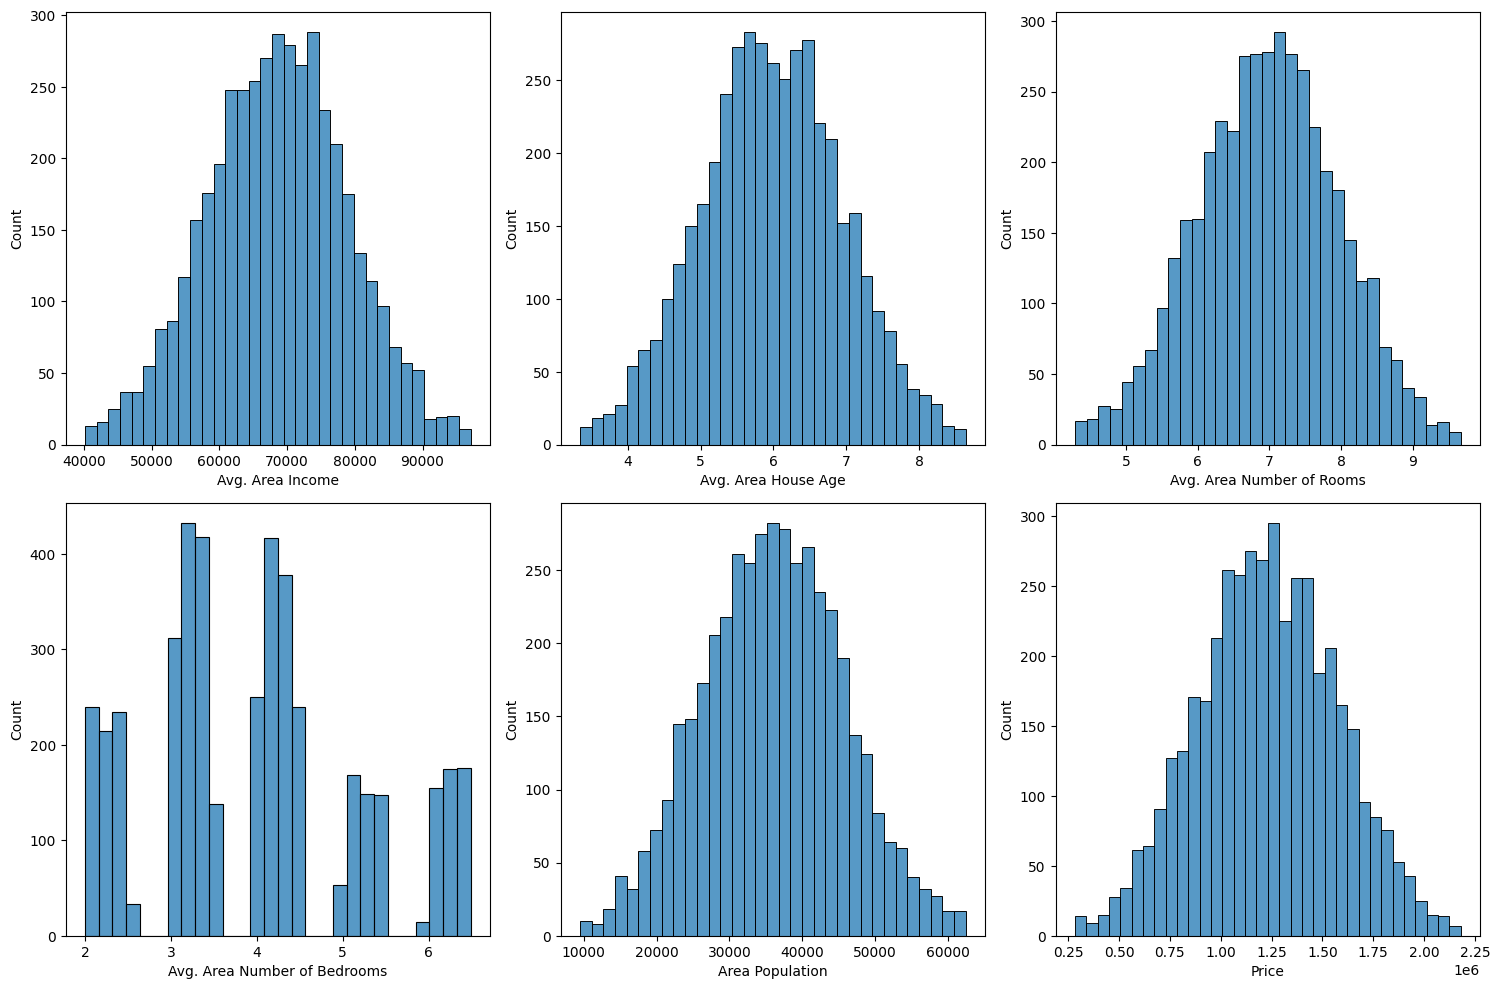

In [433]:
show_histplot(float_cols, df)

### ANOVA: Check the diff between Price and the State/City

In [434]:
city_groups = [df[df['City'] == city]['Price'] for city in df['City'].unique()]

anova_results = stats.f_oneway(*city_groups)
print(f"P-value City-Price: {anova_results.pvalue}")


P-value City-Price: 0.6419181038355266


In [435]:
state_groups = [df[df["State"] == state]["Price"] for state in df["State"].unique()]

anova_results = stats.f_oneway(*state_groups)
print(f"P-value State-Price: {anova_results.pvalue}")

P-value State-Price: 0.6975502183821739


In [436]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4344 entries, 0 to 4999
Data columns (total 10 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   Avg. Area Income              4344 non-null   float64 
 1   Avg. Area House Age           4344 non-null   float64 
 2   Avg. Area Number of Rooms     4344 non-null   float64 
 3   Avg. Area Number of Bedrooms  4344 non-null   float64 
 4   Area Population               4344 non-null   float64 
 5   Price                         4344 non-null   float64 
 6   Street                        4344 non-null   category
 7   City                          4344 non-null   category
 8   State                         4344 non-null   category
 9   Zip                           4344 non-null   category
dtypes: category(4), float64(6)
memory usage: 757.2 KB


In [437]:
float_cols

['Avg. Area Income',
 'Avg. Area House Age',
 'Avg. Area Number of Rooms',
 'Avg. Area Number of Bedrooms',
 'Area Population',
 'Price']

### Pearson

In [438]:
numerical_cols = df.select_dtypes(include=['float64']).columns

for col in numerical_cols:
    correlation, p_value = stats.pearsonr(df[col], df["Price"])
    print(f"{col} - Price korreláció: {correlation:.3f}, p-érték: {p_value:.5f}")


Avg. Area Income - Price korreláció: 0.633, p-érték: 0.00000
Avg. Area House Age - Price korreláció: 0.445, p-érték: 0.00000
Avg. Area Number of Rooms - Price korreláció: 0.328, p-érték: 0.00000
Avg. Area Number of Bedrooms - Price korreláció: 0.165, p-érték: 0.00000
Area Population - Price korreláció: 0.412, p-érték: 0.00000
Price - Price korreláció: 1.000, p-érték: 0.00000


### Spearman

In [439]:
for col in numerical_cols:
    correlation, p_value = stats.spearmanr(df[col], df["Price"])
    print(f"{col} - Price (Spearman) korreláció: {correlation:.3f}, p-érték: {p_value:.5f}")


Avg. Area Income - Price (Spearman) korreláció: 0.620, p-érték: 0.00000
Avg. Area House Age - Price (Spearman) korreláció: 0.440, p-érték: 0.00000
Avg. Area Number of Rooms - Price (Spearman) korreláció: 0.311, p-érték: 0.00000
Avg. Area Number of Bedrooms - Price (Spearman) korreláció: 0.148, p-érték: 0.00000
Area Population - Price (Spearman) korreláció: 0.398, p-érték: 0.00000
Price - Price (Spearman) korreláció: 1.000, p-érték: 0.00000


### Check if rel is linear

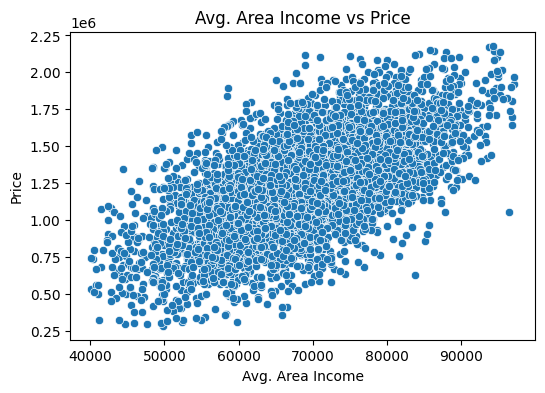

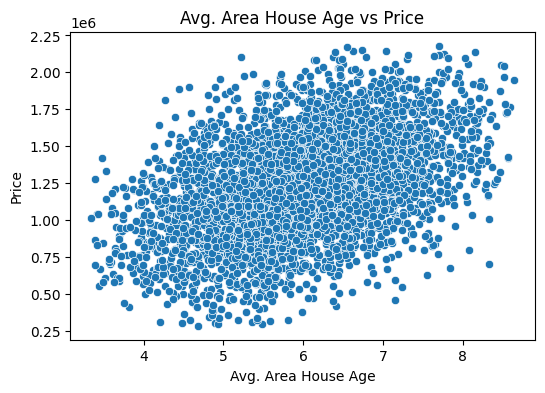

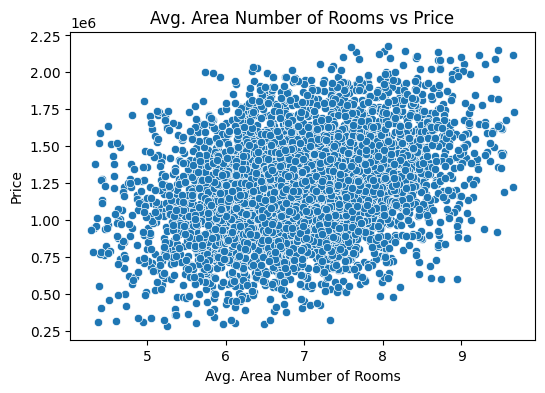

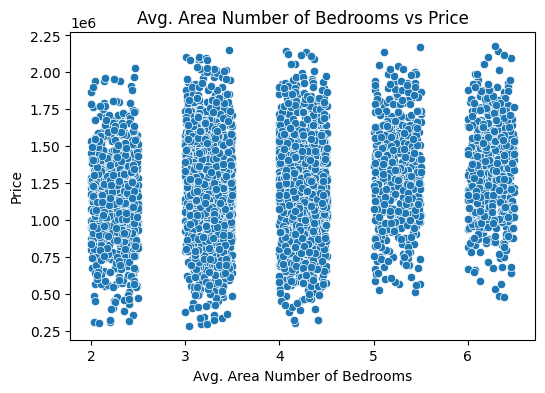

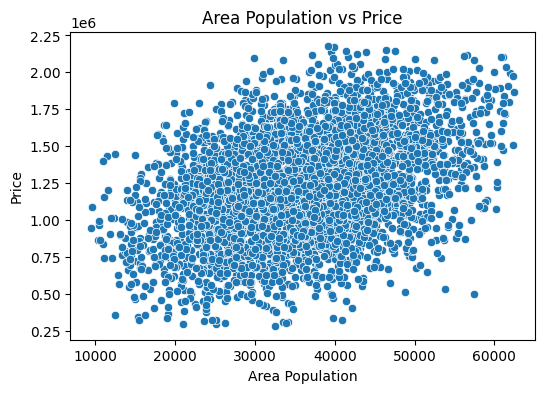

In [440]:
for col in float_cols:
  if col != "Price":
    plt.figure(figsize=(6,4))
    sns.scatterplot(x=df[col], y=df["Price"])
    plt.title(f"{col} vs Price")
    plt.show()

## Removeing unusefull data

In [442]:
df = df[float_cols]

In [443]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4344 entries, 0 to 4999
Data columns (total 6 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Avg. Area Income              4344 non-null   float64
 1   Avg. Area House Age           4344 non-null   float64
 2   Avg. Area Number of Rooms     4344 non-null   float64
 3   Avg. Area Number of Bedrooms  4344 non-null   float64
 4   Area Population               4344 non-null   float64
 5   Price                         4344 non-null   float64
dtypes: float64(6)
memory usage: 237.6 KB


## Save clean data

In [447]:
from pathlib import Path

filepath = Path("data/processed/processed_data.csv")
filepath.parent.mkdir(parents=True, exist_ok=True)
df.to_csv(filepath, index=False)